In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 16.3 MB/s eta 0:00:00


In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg19
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms
from torch import optim
import torch.nn.functional as F
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 47.2 MB/s eta 0:00:00


In [4]:
# Configs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 2e-4
EPOCHS = 100
BATCH_SIZE = 8
NUM_WORKERS = 2
LOW_RES_SIZE = 128
HIGH_RES_SIZE = 256
SAVE_INTERVAL = 10

In [5]:
# Image Transformations
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((LOW_RES_SIZE, LOW_RES_SIZE)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((HIGH_RES_SIZE, HIGH_RES_SIZE)),
    transforms.ToTensor(),
])

In [6]:
# Handling Created Dataset
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        super().__init__()
        self.root_dir = root_dir
        self.files_low = sorted(os.listdir(os.path.join(root_dir, "low_res")))
        self.files_high = sorted(os.listdir(os.path.join(root_dir, "high_res")))

    def __len__(self):
        return len(self.files_low)

    def __getitem__(self, index):
        low_res_path = os.path.join(self.root_dir, "low_res", self.files_low[index])
        high_res_path = os.path.join(self.root_dir, "high_res", self.files_high[index])

        low_res = np.array(Image.open(low_res_path))
        high_res = np.array(Image.open(high_res_path))

        # Handle RGBA images
        if low_res.shape[-1] == 4:
            low_res = low_res[..., :3]
        if high_res.shape[-1] == 4:
            high_res = high_res[..., :3]

        return transform_low(low_res), transform_high(high_res)

In [7]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=16):
        super().__init__()

        # Initial convolution
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, num_channels, kernel_size=9, padding=4),
            nn.PReLU()
        )

        # Residual blocks
        res_blocks = []
        for _ in range(num_blocks):
            res_blocks.append(ResidualBlock(num_channels))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Post-residual convolution
        self.conv_after_res = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(num_channels)

        # Upsampling blocks
        self.upsampling = nn.Sequential(
            UpsampleBlock(num_channels, 2),
            nn.Conv2d(num_channels, in_channels, kernel_size=9, padding=4),
            nn.Tanh()
        )

    def forward(self, x):
        initial = self.initial(x)
        res_out = self.res_blocks(initial)
        res_conv = self.bn(self.conv_after_res(res_out))
        out = torch.add(initial, res_conv)
        out = self.upsampling(out)
        return out

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def discriminator_block(in_channels, out_channels, stride, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, 3, stride, 1)]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(3, 64, 1, False),
            *discriminator_block(64, 64, 2),
            *discriminator_block(64, 128, 1),
            *discriminator_block(128, 128, 2),
            *discriminator_block(128, 256, 1),
            *discriminator_block(256, 256, 2),
            *discriminator_block(256, 512, 1),
            *discriminator_block(512, 512, 2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return self.model(x)


In [9]:
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval().to(DEVICE)
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.loss = nn.MSELoss()

    def forward(self, sr, hr):
        sr_features = self.vgg(sr)
        hr_features = self.vgg(hr)
        return self.loss(sr_features, hr_features)

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out

class UpsampleBlock(nn.Module):
    def __init__(self, channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels * scale_factor ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x


In [11]:
def train_model(train_loader, val_loader, generator, discriminator, epochs):
    # Initialize optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(0.9, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.9, 0.999))

    # Initialize loss functions
    content_loss = nn.MSELoss().to(DEVICE)
    adversarial_loss = nn.BCEWithLogitsLoss().to(DEVICE)
    vgg_loss = VGGLoss().to(DEVICE)

    # Initialize metrics
    psnr_metric = PeakSignalNoiseRatio().to(DEVICE)
    ssim_metric = StructuralSimilarityIndexMeasure().to(DEVICE)

    # Training loop
    for epoch in range(epochs):
        generator.train()
        discriminator.train()

        # Metrics for current epoch
        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_psnr = 0
        epoch_ssim = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (lr_imgs, hr_imgs) in enumerate(progress_bar):
            batch_size = lr_imgs.size(0)

            # Move images to device
            lr_imgs = lr_imgs.to(DEVICE)
            hr_imgs = hr_imgs.to(DEVICE)

            # Train Discriminator
            optimizer_D.zero_grad()

            generated_imgs = generator(lr_imgs)

            real_validity = discriminator(hr_imgs)
            fake_validity = discriminator(generated_imgs.detach())

            d_loss_real = adversarial_loss(real_validity, torch.ones_like(real_validity))
            d_loss_fake = adversarial_loss(fake_validity, torch.zeros_like(fake_validity))

            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            # Calculate losses
            gen_validity = discriminator(generated_imgs)

            pixel_loss = content_loss(generated_imgs, hr_imgs)
            perceptual_loss = vgg_loss(generated_imgs, hr_imgs)
            gen_adv_loss = adversarial_loss(gen_validity, torch.ones_like(gen_validity))

            g_loss = pixel_loss + 0.006 * perceptual_loss + 0.001 * gen_adv_loss

            g_loss.backward()
            optimizer_G.step()

            # Calculate metrics
            with torch.no_grad():
                psnr_val = psnr_metric(generated_imgs, hr_imgs)
                ssim_val = ssim_metric(generated_imgs, hr_imgs)

                epoch_g_loss += g_loss.item()
                epoch_d_loss += d_loss.item()
                epoch_psnr += psnr_val.item()
                epoch_ssim += ssim_val.item()

            # Update progress bar
            progress_bar.set_postfix({
                'G_Loss': f'{g_loss.item():.4f}',
                'D_Loss': f'{d_loss.item():.4f}',
                'PSNR': f'{psnr_val.item():.2f}',
                'SSIM': f'{ssim_val.item():.4f}'
            })

        # Calculate epoch averages
        num_batches = len(train_loader)
        avg_g_loss = epoch_g_loss / num_batches
        avg_d_loss = epoch_d_loss / num_batches
        avg_psnr = epoch_psnr / num_batches
        avg_ssim = epoch_ssim / num_batches

        print(f"\nEpoch {epoch+1} Results:")
        print(f"Average Generator Loss: {avg_g_loss:.4f}")
        print(f"Average Discriminator Loss: {avg_d_loss:.4f}")
        print(f"Average PSNR: {avg_psnr:.2f}")
        print(f"Average SSIM: {avg_ssim:.4f}")

        # Save model checkpoints every SAVE_INTERVAL epochs
        if (epoch + 1) % SAVE_INTERVAL == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'g_loss': avg_g_loss,
                'd_loss': avg_d_loss,
                'psnr': avg_psnr,
                'ssim': avg_ssim
            }
            torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pth')

        # Validation phase
        if val_loader is not None:
            generator.eval()
            val_psnr = 0
            val_ssim = 0

            with torch.no_grad():
                for lr_imgs, hr_imgs in val_loader:
                    lr_imgs = lr_imgs.to(DEVICE)
                    hr_imgs = hr_imgs.to(DEVICE)

                    generated_imgs = generator(lr_imgs)

                    val_psnr += psnr_metric(generated_imgs, hr_imgs).item()
                    val_ssim += ssim_metric(generated_imgs, hr_imgs).item()

            val_psnr /= len(val_loader)
            val_ssim /= len(val_loader)

            print(f"Validation PSNR: {val_psnr:.2f}")
            print(f"Validation SSIM: {val_ssim:.4f}")


In [15]:
import os
print("WE HAVE OUR DATASET FOR MODEL TRAINING: ")
print("Number of high resolution Training images : ",len(os.listdir('/content/drive/MyDrive/dataset/train/high_res/')))
print("Number of high resolution validation images : ",len(os.listdir('/content/drive/MyDrive/dataset/val/high_res/')))
print("Number of low resolution Training images : ",len(os.listdir('/content/drive/MyDrive/dataset/train/low_res/')))
print("Number of low resolution validation images : ",len(os.listdir('/content/drive/MyDrive/dataset/val/low_res/')))

WE HAVE OUR DATASET FOR MODEL TRAINING: 
Number of high resolution Training images :  685
Number of high resolution validation images :  170
Number of low resolution Training images :  685
Number of low resolution validation images :  170


In [ ]:

def main():
    # Create datasets and dataloaders
    train_dataset = ImageDataset(root_dir="/content/drive/MyDrive/dataset/train")
    val_dataset = ImageDataset(root_dir="/content/drive/MyDrive/dataset/train")

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    # Initialize models
    generator = Generator().to(DEVICE)
    discriminator = Discriminator().to(DEVICE)

    # Train the model
    train_model(train_loader, val_loader, generator, discriminator, EPOCHS)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 208MB/s]  
Epoch 1/100: 100%|██████████| 86/86 [01:19<00:00,  1.08it/s, G_Loss=0.0094, D_Loss=0.6553, PSNR=21.24, SSIM=0.5839]


Epoch 1 Results:
Average Generator Loss: 0.0233
Average Discriminator Loss: 0.6616
Average PSNR: 18.45
Average SSIM: 0.5195


Validation PSNR: 21.29
Validation SSIM: 0.6146


Epoch 2/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0051, D_Loss=0.6947, PSNR=24.37, SSIM=0.7737]


Epoch 2 Results:
Average Generator Loss: 0.0089
Average Discriminator Loss: 0.6788
Average PSNR: 21.71
Average SSIM: 0.6663


Validation PSNR: 23.51
Validation SSIM: 0.7155


Epoch 3/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0068, D_Loss=0.6882, PSNR=22.73, SSIM=0.7836]


Epoch 3 Results:
Average Generator Loss: 0.0067
Average Discriminator Loss: 0.6909
Average PSNR: 23.05
Average SSIM: 0.7351


Validation PSNR: 24.53
Validation SSIM: 0.7624


Epoch 4/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0110, D_Loss=0.5725, PSNR=20.19, SSIM=0.7737]


Epoch 4 Results:
Average Generator Loss: 0.0058
Average Discriminator Loss: 0.6688
Average PSNR: 23.79
Average SSIM: 0.7705


Validation PSNR: 21.93
Validation SSIM: 0.7639


Epoch 5/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0041, D_Loss=0.6860, PSNR=25.47, SSIM=0.8332]


Epoch 5 Results:
Average Generator Loss: 0.0051
Average Discriminator Loss: 0.6766
Average PSNR: 24.51
Average SSIM: 0.7878


Validation PSNR: 22.75
Validation SSIM: 0.7805


Epoch 6/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0039, D_Loss=0.6190, PSNR=26.02, SSIM=0.8622]


Epoch 6 Results:
Average Generator Loss: 0.0050
Average Discriminator Loss: 0.6773
Average PSNR: 24.65
Average SSIM: 0.8019


Validation PSNR: 25.78
Validation SSIM: 0.8164


Epoch 7/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0041, D_Loss=0.6616, PSNR=25.85, SSIM=0.8130]


Epoch 7 Results:
Average Generator Loss: 0.0043
Average Discriminator Loss: 0.6771
Average PSNR: 25.53
Average SSIM: 0.8235


Validation PSNR: 26.40
Validation SSIM: 0.8255


Epoch 8/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0048, D_Loss=0.7436, PSNR=24.35, SSIM=0.8412]


Epoch 8 Results:
Average Generator Loss: 0.0044
Average Discriminator Loss: 0.6465
Average PSNR: 25.46
Average SSIM: 0.8256


Validation PSNR: 25.77
Validation SSIM: 0.8056


Epoch 9/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0039, D_Loss=0.5808, PSNR=26.25, SSIM=0.8588]


Epoch 9 Results:
Average Generator Loss: 0.0043
Average Discriminator Loss: 0.6280
Average PSNR: 25.57
Average SSIM: 0.8328


Validation PSNR: 25.43
Validation SSIM: 0.8232


Epoch 10/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0036, D_Loss=0.6746, PSNR=25.94, SSIM=0.8387]



Epoch 10 Results:
Average Generator Loss: 0.0041
Average Discriminator Loss: 0.6433
Average PSNR: 25.95
Average SSIM: 0.8338
Validation PSNR: 25.28
Validation SSIM: 0.8097


Epoch 11/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0042, D_Loss=0.5542, PSNR=25.74, SSIM=0.8132]


Epoch 11 Results:
Average Generator Loss: 0.0043
Average Discriminator Loss: 0.6570
Average PSNR: 25.61
Average SSIM: 0.8275


Validation PSNR: 25.43
Validation SSIM: 0.8237


Epoch 12/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0052, D_Loss=0.5105, PSNR=24.78, SSIM=0.8208]


Epoch 12 Results:
Average Generator Loss: 0.0043
Average Discriminator Loss: 0.6383
Average PSNR: 25.64
Average SSIM: 0.8251


Validation PSNR: 25.40
Validation SSIM: 0.8177


Epoch 13/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0035, D_Loss=0.7600, PSNR=27.34, SSIM=0.8528]


Epoch 13 Results:
Average Generator Loss: 0.0039
Average Discriminator Loss: 0.6546
Average PSNR: 26.18
Average SSIM: 0.8328


Validation PSNR: 26.67
Validation SSIM: 0.8523


Epoch 14/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0043, D_Loss=0.5182, PSNR=26.11, SSIM=0.8261]


Epoch 14 Results:
Average Generator Loss: 0.0034
Average Discriminator Loss: 0.6607
Average PSNR: 26.80
Average SSIM: 0.8570


Validation PSNR: 26.77
Validation SSIM: 0.8575


Epoch 15/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0064, D_Loss=0.5888, PSNR=23.17, SSIM=0.8323]


Epoch 15 Results:
Average Generator Loss: 0.0040
Average Discriminator Loss: 0.5876
Average PSNR: 26.19
Average SSIM: 0.8402


Validation PSNR: 24.44
Validation SSIM: 0.8198


Epoch 16/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0063, D_Loss=0.3133, PSNR=23.83, SSIM=0.7772]


Epoch 16 Results:
Average Generator Loss: 0.0039
Average Discriminator Loss: 0.6245
Average PSNR: 26.23
Average SSIM: 0.8277


Validation PSNR: 26.58
Validation SSIM: 0.8352


Epoch 17/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0026, D_Loss=0.7073, PSNR=27.86, SSIM=0.8599]


Epoch 17 Results:
Average Generator Loss: 0.0040
Average Discriminator Loss: 0.6668
Average PSNR: 26.06
Average SSIM: 0.8308


Validation PSNR: 26.78
Validation SSIM: 0.8435


Epoch 18/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0036, D_Loss=0.5360, PSNR=26.41, SSIM=0.8159]


Epoch 18 Results:
Average Generator Loss: 0.0037
Average Discriminator Loss: 0.6539
Average PSNR: 26.45
Average SSIM: 0.8390


Validation PSNR: 27.04
Validation SSIM: 0.8528


Epoch 19/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0040, D_Loss=0.5535, PSNR=25.55, SSIM=0.8077]


Epoch 19 Results:
Average Generator Loss: 0.0039
Average Discriminator Loss: 0.6369
Average PSNR: 26.15
Average SSIM: 0.8394


Validation PSNR: 27.07
Validation SSIM: 0.8541


Epoch 20/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0035, D_Loss=0.9965, PSNR=26.58, SSIM=0.8577]



Epoch 20 Results:
Average Generator Loss: 0.0036
Average Discriminator Loss: 0.6314
Average PSNR: 26.70
Average SSIM: 0.8473
Validation PSNR: 25.53
Validation SSIM: 0.8142


Epoch 21/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0037, D_Loss=0.6757, PSNR=25.42, SSIM=0.8562]


Epoch 21 Results:
Average Generator Loss: 0.0035
Average Discriminator Loss: 0.6408
Average PSNR: 26.72
Average SSIM: 0.8495


Validation PSNR: 26.57
Validation SSIM: 0.8544


Epoch 22/100: 100%|██████████| 86/86 [01:21<00:00,  1.05it/s, G_Loss=0.0039, D_Loss=0.4420, PSNR=26.43, SSIM=0.8550]


Epoch 22 Results:
Average Generator Loss: 0.0037
Average Discriminator Loss: 0.6471
Average PSNR: 26.54
Average SSIM: 0.8479


Validation PSNR: 27.13
Validation SSIM: 0.8561


Epoch 23/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0026, D_Loss=0.9329, PSNR=27.66, SSIM=0.8134]


Epoch 23 Results:
Average Generator Loss: 0.0038
Average Discriminator Loss: 0.6478
Average PSNR: 26.35
Average SSIM: 0.8423


Validation PSNR: 25.78
Validation SSIM: 0.8233


Epoch 24/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0020, D_Loss=0.6713, PSNR=30.03, SSIM=0.9113]


Epoch 24 Results:
Average Generator Loss: 0.0034
Average Discriminator Loss: 0.6992
Average PSNR: 26.85
Average SSIM: 0.8498


Validation PSNR: 27.99
Validation SSIM: 0.8731


Epoch 25/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0027, D_Loss=0.5965, PSNR=27.58, SSIM=0.8760]


Epoch 25 Results:
Average Generator Loss: 0.0034
Average Discriminator Loss: 0.6060
Average PSNR: 27.12
Average SSIM: 0.8626


Validation PSNR: 27.17
Validation SSIM: 0.8593


Epoch 26/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0031, D_Loss=0.7840, PSNR=27.34, SSIM=0.8880]


Epoch 26 Results:
Average Generator Loss: 0.0039
Average Discriminator Loss: 0.6603
Average PSNR: 26.21
Average SSIM: 0.8411


Validation PSNR: 26.67
Validation SSIM: 0.8423


Epoch 27/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0056, D_Loss=0.7374, PSNR=24.56, SSIM=0.8460]


Epoch 27 Results:
Average Generator Loss: 0.0036
Average Discriminator Loss: 0.5985
Average PSNR: 26.76
Average SSIM: 0.8553


Validation PSNR: 26.21
Validation SSIM: 0.8443


Epoch 28/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0034, D_Loss=0.4764, PSNR=27.27, SSIM=0.8768]


Epoch 28 Results:
Average Generator Loss: 0.0034
Average Discriminator Loss: 0.6384
Average PSNR: 26.91
Average SSIM: 0.8490


Validation PSNR: 26.71
Validation SSIM: 0.8523


Epoch 29/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0041, D_Loss=0.4194, PSNR=26.20, SSIM=0.8548]


Epoch 29 Results:
Average Generator Loss: 0.0039
Average Discriminator Loss: 0.6405
Average PSNR: 26.12
Average SSIM: 0.8424


Validation PSNR: 26.76
Validation SSIM: 0.8392


Epoch 30/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0039, D_Loss=0.5858, PSNR=26.05, SSIM=0.7870]


Epoch 30 Results:
Average Generator Loss: 0.0037
Average Discriminator Loss: 0.6366
Average PSNR: 26.43
Average SSIM: 0.8479


Validation PSNR: 24.62
Validation SSIM: 0.8433


Epoch 31/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0040, D_Loss=0.6071, PSNR=26.01, SSIM=0.8238]


Epoch 31 Results:
Average Generator Loss: 0.0037
Average Discriminator Loss: 0.6512
Average PSNR: 26.57
Average SSIM: 0.8437


Validation PSNR: 27.09
Validation SSIM: 0.8580


Epoch 32/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0044, D_Loss=0.7064, PSNR=25.71, SSIM=0.8428]


Epoch 32 Results:
Average Generator Loss: 0.0041
Average Discriminator Loss: 0.6462
Average PSNR: 25.85
Average SSIM: 0.8308


Validation PSNR: 26.27
Validation SSIM: 0.8277


Epoch 33/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0033, D_Loss=0.6131, PSNR=27.93, SSIM=0.8529]


Epoch 33 Results:
Average Generator Loss: 0.0036
Average Discriminator Loss: 0.6278
Average PSNR: 26.56
Average SSIM: 0.8413


Validation PSNR: 25.95
Validation SSIM: 0.8545


Epoch 34/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0028, D_Loss=0.7104, PSNR=27.21, SSIM=0.8393]


Epoch 34 Results:
Average Generator Loss: 0.0036
Average Discriminator Loss: 0.6581
Average PSNR: 26.54
Average SSIM: 0.8501


Validation PSNR: 26.68
Validation SSIM: 0.8437


Epoch 35/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0037, D_Loss=0.7812, PSNR=27.51, SSIM=0.8883]


Epoch 35 Results:
Average Generator Loss: 0.0034
Average Discriminator Loss: 0.6240
Average PSNR: 26.95
Average SSIM: 0.8578


Validation PSNR: 27.35
Validation SSIM: 0.8540


Epoch 36/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0051, D_Loss=1.2452, PSNR=26.15, SSIM=0.8315]


Epoch 36 Results:
Average Generator Loss: 0.0036
Average Discriminator Loss: 0.5630
Average PSNR: 27.04
Average SSIM: 0.8568


Validation PSNR: 26.04
Validation SSIM: 0.8126


Epoch 37/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0030, D_Loss=0.7042, PSNR=27.56, SSIM=0.8790]


Epoch 37 Results:
Average Generator Loss: 0.0036
Average Discriminator Loss: 0.6641
Average PSNR: 26.71
Average SSIM: 0.8430


Validation PSNR: 26.22
Validation SSIM: 0.8337


Epoch 38/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0025, D_Loss=0.4683, PSNR=29.30, SSIM=0.8939]


Epoch 38 Results:
Average Generator Loss: 0.0034
Average Discriminator Loss: 0.6177
Average PSNR: 27.03
Average SSIM: 0.8559


Validation PSNR: 27.96
Validation SSIM: 0.8666


Epoch 39/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0029, D_Loss=0.5599, PSNR=28.39, SSIM=0.9026]


Epoch 39 Results:
Average Generator Loss: 0.0035
Average Discriminator Loss: 0.6641
Average PSNR: 27.04
Average SSIM: 0.8478


Validation PSNR: 27.87
Validation SSIM: 0.8736


Epoch 40/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0038, D_Loss=0.6567, PSNR=25.58, SSIM=0.8564]


Epoch 40 Results:
Average Generator Loss: 0.0035
Average Discriminator Loss: 0.6167
Average PSNR: 26.89
Average SSIM: 0.8562


Validation PSNR: 25.06
Validation SSIM: 0.8467


Epoch 41/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0024, D_Loss=0.5719, PSNR=29.38, SSIM=0.9135]


Epoch 41 Results:
Average Generator Loss: 0.0034
Average Discriminator Loss: 0.6630
Average PSNR: 26.93
Average SSIM: 0.8616


Validation PSNR: 27.69
Validation SSIM: 0.8781


Epoch 42/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0035, D_Loss=0.3293, PSNR=26.97, SSIM=0.8744]


Epoch 42 Results:
Average Generator Loss: 0.0036
Average Discriminator Loss: 0.5986
Average PSNR: 26.96
Average SSIM: 0.8586


Validation PSNR: 28.16
Validation SSIM: 0.8666


Epoch 43/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0036, D_Loss=0.6024, PSNR=26.76, SSIM=0.8778]


Epoch 43 Results:
Average Generator Loss: 0.0035
Average Discriminator Loss: 0.6288
Average PSNR: 26.96
Average SSIM: 0.8479


Validation PSNR: 26.97
Validation SSIM: 0.8541


Epoch 44/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0034, D_Loss=0.6214, PSNR=27.27, SSIM=0.8873]


Epoch 44 Results:
Average Generator Loss: 0.0031
Average Discriminator Loss: 0.6734
Average PSNR: 27.50
Average SSIM: 0.8719


Validation PSNR: 28.66
Validation SSIM: 0.8835


Epoch 45/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0037, D_Loss=0.7101, PSNR=26.16, SSIM=0.8328]


Epoch 45 Results:
Average Generator Loss: 0.0030
Average Discriminator Loss: 0.6901
Average PSNR: 27.68
Average SSIM: 0.8698


Validation PSNR: 28.05
Validation SSIM: 0.8781


Epoch 46/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0023, D_Loss=0.6986, PSNR=29.16, SSIM=0.9039]


Epoch 46 Results:
Average Generator Loss: 0.0024
Average Discriminator Loss: 0.6957
Average PSNR: 28.72
Average SSIM: 0.8945


Validation PSNR: 28.73
Validation SSIM: 0.8956


Epoch 47/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0026, D_Loss=0.6734, PSNR=28.58, SSIM=0.9229]


Epoch 47 Results:
Average Generator Loss: 0.0024
Average Discriminator Loss: 0.6871
Average PSNR: 28.92
Average SSIM: 0.8998


Validation PSNR: 28.41
Validation SSIM: 0.8921


Epoch 48/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0034, D_Loss=0.7678, PSNR=26.07, SSIM=0.7819]


Epoch 48 Results:
Average Generator Loss: 0.0027
Average Discriminator Loss: 0.5559
Average PSNR: 28.49
Average SSIM: 0.8893


Validation PSNR: 27.08
Validation SSIM: 0.8381


Epoch 49/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0060, D_Loss=0.8950, PSNR=23.85, SSIM=0.7895]


Epoch 49 Results:
Average Generator Loss: 0.0034
Average Discriminator Loss: 0.6515
Average PSNR: 27.03
Average SSIM: 0.8683


Validation PSNR: 26.68
Validation SSIM: 0.8462


Epoch 50/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0031, D_Loss=0.9019, PSNR=26.73, SSIM=0.8579]


Epoch 50 Results:
Average Generator Loss: 0.0035
Average Discriminator Loss: 0.6564
Average PSNR: 26.91
Average SSIM: 0.8495


Validation PSNR: 26.25
Validation SSIM: 0.8555


Epoch 51/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0025, D_Loss=0.6409, PSNR=27.99, SSIM=0.8444]


Epoch 51 Results:
Average Generator Loss: 0.0040
Average Discriminator Loss: 0.6710
Average PSNR: 25.97
Average SSIM: 0.8498


Validation PSNR: 26.71
Validation SSIM: 0.8525


Epoch 52/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0021, D_Loss=0.7027, PSNR=29.38, SSIM=0.8880]


Epoch 52 Results:
Average Generator Loss: 0.0034
Average Discriminator Loss: 0.6477
Average PSNR: 27.02
Average SSIM: 0.8683


Validation PSNR: 28.12
Validation SSIM: 0.8816


Epoch 53/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0028, D_Loss=0.8488, PSNR=26.96, SSIM=0.8275]


Epoch 53 Results:
Average Generator Loss: 0.0029
Average Discriminator Loss: 0.5525
Average PSNR: 28.16
Average SSIM: 0.8844


Validation PSNR: 26.82
Validation SSIM: 0.8493


Epoch 54/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0027, D_Loss=0.6694, PSNR=27.58, SSIM=0.8453]


Epoch 54 Results:
Average Generator Loss: 0.0036
Average Discriminator Loss: 0.6772
Average PSNR: 26.67
Average SSIM: 0.8527


Validation PSNR: 26.40
Validation SSIM: 0.8156


Epoch 55/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0057, D_Loss=1.5448, PSNR=25.28, SSIM=0.8553]


Epoch 55 Results:
Average Generator Loss: 0.0032
Average Discriminator Loss: 0.6237
Average PSNR: 27.62
Average SSIM: 0.8619


Validation PSNR: 26.99
Validation SSIM: 0.8577


Epoch 56/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0027, D_Loss=0.6729, PSNR=28.23, SSIM=0.8878]


Epoch 56 Results:
Average Generator Loss: 0.0027
Average Discriminator Loss: 0.7463
Average PSNR: 28.45
Average SSIM: 0.8880


Validation PSNR: 28.77
Validation SSIM: 0.8922


Epoch 57/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0034, D_Loss=0.5833, PSNR=26.74, SSIM=0.8907]


Epoch 57 Results:
Average Generator Loss: 0.0024
Average Discriminator Loss: 0.6330
Average PSNR: 29.10
Average SSIM: 0.9016


Validation PSNR: 29.19
Validation SSIM: 0.8979


Epoch 58/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0037, D_Loss=0.6792, PSNR=27.13, SSIM=0.8645]


Epoch 58 Results:
Average Generator Loss: 0.0031
Average Discriminator Loss: 0.5594
Average PSNR: 28.02
Average SSIM: 0.8780


Validation PSNR: 26.41
Validation SSIM: 0.8278


Epoch 59/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0028, D_Loss=0.7758, PSNR=28.63, SSIM=0.9211]


Epoch 59 Results:
Average Generator Loss: 0.0032
Average Discriminator Loss: 0.6642
Average PSNR: 27.27
Average SSIM: 0.8691


Validation PSNR: 27.70
Validation SSIM: 0.8738


Epoch 60/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0029, D_Loss=0.6305, PSNR=27.72, SSIM=0.8891]


Epoch 60 Results:
Average Generator Loss: 0.0029
Average Discriminator Loss: 0.6632
Average PSNR: 28.10
Average SSIM: 0.8789


Validation PSNR: 28.72
Validation SSIM: 0.8793


Epoch 61/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0026, D_Loss=0.6703, PSNR=27.96, SSIM=0.8404]


Epoch 61 Results:
Average Generator Loss: 0.0030
Average Discriminator Loss: 0.6754
Average PSNR: 27.63
Average SSIM: 0.8651


Validation PSNR: 26.90
Validation SSIM: 0.8687


Epoch 62/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0035, D_Loss=0.6666, PSNR=26.75, SSIM=0.8730]


Epoch 62 Results:
Average Generator Loss: 0.0029
Average Discriminator Loss: 0.6549
Average PSNR: 27.94
Average SSIM: 0.8675


Validation PSNR: 27.29
Validation SSIM: 0.8440


Epoch 63/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0019, D_Loss=0.9747, PSNR=29.69, SSIM=0.8834]


Epoch 63 Results:
Average Generator Loss: 0.0028
Average Discriminator Loss: 0.6450
Average PSNR: 28.23
Average SSIM: 0.8817


Validation PSNR: 27.36
Validation SSIM: 0.8754


Epoch 64/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0024, D_Loss=0.6490, PSNR=28.76, SSIM=0.8735]


Epoch 64 Results:
Average Generator Loss: 0.0028
Average Discriminator Loss: 0.6802
Average PSNR: 28.02
Average SSIM: 0.8770


Validation PSNR: 27.65
Validation SSIM: 0.8722


Epoch 65/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0022, D_Loss=0.4523, PSNR=29.21, SSIM=0.9051]


Epoch 65 Results:
Average Generator Loss: 0.0027
Average Discriminator Loss: 0.6673
Average PSNR: 28.17
Average SSIM: 0.8816


Validation PSNR: 28.79
Validation SSIM: 0.8923


Epoch 66/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0035, D_Loss=0.6896, PSNR=26.47, SSIM=0.8196]


Epoch 66 Results:
Average Generator Loss: 0.0027
Average Discriminator Loss: 0.6038
Average PSNR: 28.39
Average SSIM: 0.8860


Validation PSNR: 26.95
Validation SSIM: 0.8527


Epoch 67/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0026, D_Loss=0.5946, PSNR=28.31, SSIM=0.8692]


Epoch 67 Results:
Average Generator Loss: 0.0029
Average Discriminator Loss: 0.6811
Average PSNR: 27.85
Average SSIM: 0.8765


Validation PSNR: 28.84
Validation SSIM: 0.8968


Epoch 68/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0021, D_Loss=0.7038, PSNR=29.13, SSIM=0.9150]


Epoch 68 Results:
Average Generator Loss: 0.0027
Average Discriminator Loss: 0.6628
Average PSNR: 28.33
Average SSIM: 0.8823


Validation PSNR: 29.20
Validation SSIM: 0.8959


Epoch 69/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0024, D_Loss=0.4068, PSNR=29.22, SSIM=0.8903]


Epoch 69 Results:
Average Generator Loss: 0.0023
Average Discriminator Loss: 0.5871
Average PSNR: 29.30
Average SSIM: 0.9005


Validation PSNR: 28.00
Validation SSIM: 0.8726


Epoch 70/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0032, D_Loss=0.6231, PSNR=26.74, SSIM=0.9130]


Epoch 70 Results:
Average Generator Loss: 0.0027
Average Discriminator Loss: 0.6736
Average PSNR: 28.27
Average SSIM: 0.8852


Validation PSNR: 29.00
Validation SSIM: 0.8896


Epoch 71/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0038, D_Loss=0.4788, PSNR=26.06, SSIM=0.8518]


Epoch 71 Results:
Average Generator Loss: 0.0026
Average Discriminator Loss: 0.6217
Average PSNR: 28.66
Average SSIM: 0.8861


Validation PSNR: 28.47
Validation SSIM: 0.8685


Epoch 72/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0019, D_Loss=0.5107, PSNR=31.07, SSIM=0.9298]


Epoch 72 Results:
Average Generator Loss: 0.0025
Average Discriminator Loss: 0.6752
Average PSNR: 28.84
Average SSIM: 0.8937


Validation PSNR: 29.18
Validation SSIM: 0.8989


Epoch 73/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0025, D_Loss=0.7521, PSNR=28.46, SSIM=0.8783]


Epoch 73 Results:
Average Generator Loss: 0.0028
Average Discriminator Loss: 0.6656
Average PSNR: 28.03
Average SSIM: 0.8781


Validation PSNR: 28.13
Validation SSIM: 0.8932


Epoch 74/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0022, D_Loss=0.9257, PSNR=28.87, SSIM=0.8366]


Epoch 74 Results:
Average Generator Loss: 0.0026
Average Discriminator Loss: 0.6854
Average PSNR: 28.28
Average SSIM: 0.8867


Validation PSNR: 27.51
Validation SSIM: 0.8663


Epoch 75/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0028, D_Loss=0.6610, PSNR=27.10, SSIM=0.8783]


Epoch 75 Results:
Average Generator Loss: 0.0027
Average Discriminator Loss: 0.6520
Average PSNR: 28.08
Average SSIM: 0.8856


Validation PSNR: 28.53
Validation SSIM: 0.8889


Epoch 76/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0021, D_Loss=0.6538, PSNR=30.47, SSIM=0.9133]


Epoch 76 Results:
Average Generator Loss: 0.0027
Average Discriminator Loss: 0.6778
Average PSNR: 28.05
Average SSIM: 0.8780


Validation PSNR: 29.01
Validation SSIM: 0.8955


Epoch 77/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0031, D_Loss=0.7265, PSNR=28.25, SSIM=0.8585]


Epoch 77 Results:
Average Generator Loss: 0.0027
Average Discriminator Loss: 0.6570
Average PSNR: 28.30
Average SSIM: 0.8855


Validation PSNR: 28.45
Validation SSIM: 0.8726


Epoch 78/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0021, D_Loss=0.9670, PSNR=28.41, SSIM=0.8724]


Epoch 78 Results:
Average Generator Loss: 0.0026
Average Discriminator Loss: 0.6455
Average PSNR: 28.56
Average SSIM: 0.8903


Validation PSNR: 27.43
Validation SSIM: 0.8625


Epoch 79/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0025, D_Loss=0.3660, PSNR=28.61, SSIM=0.8810]


Epoch 79 Results:
Average Generator Loss: 0.0025
Average Discriminator Loss: 0.6591
Average PSNR: 28.75
Average SSIM: 0.8895


Validation PSNR: 29.65
Validation SSIM: 0.9038


Epoch 80/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0028, D_Loss=0.7081, PSNR=28.73, SSIM=0.8751]


Epoch 80 Results:
Average Generator Loss: 0.0025
Average Discriminator Loss: 0.6696
Average PSNR: 28.56
Average SSIM: 0.8876


Validation PSNR: 28.88
Validation SSIM: 0.8880


Epoch 81/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0151, D_Loss=0.6741, PSNR=18.58, SSIM=0.5733]


Epoch 81 Results:
Average Generator Loss: 0.0027
Average Discriminator Loss: 0.6736
Average PSNR: 28.23
Average SSIM: 0.8806


Validation PSNR: 25.56
Validation SSIM: 0.8676


Epoch 82/100: 100%|██████████| 86/86 [01:21<00:00,  1.06it/s, G_Loss=0.0065, D_Loss=0.5936, PSNR=23.90, SSIM=0.7854]


Epoch 82 Results:
Average Generator Loss: 0.0071
Average Discriminator Loss: 0.4719
Average PSNR: 23.11
Average SSIM: 0.7917


Validation PSNR: 23.41
Validation SSIM: 0.7477


Epoch 83/100: 100%|██████████| 86/86 [01:20<00:00,  1.06it/s, G_Loss=0.0040, D_Loss=0.2513, PSNR=26.33, SSIM=0.8524]


Epoch 83 Results:
Average Generator Loss: 0.0045
Average Discriminator Loss: 0.5826
Average PSNR: 25.71
Average SSIM: 0.8360


Validation PSNR: 27.08
Validation SSIM: 0.8632


Epoch 84/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0050, D_Loss=0.4381, PSNR=24.66, SSIM=0.8904]


Epoch 84 Results:
Average Generator Loss: 0.0041
Average Discriminator Loss: 0.6482
Average PSNR: 26.44
Average SSIM: 0.8525


Validation PSNR: 27.53
Validation SSIM: 0.8752


Epoch 85/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0030, D_Loss=0.7320, PSNR=27.60, SSIM=0.8599]


Epoch 85 Results:
Average Generator Loss: 0.0034
Average Discriminator Loss: 0.5604
Average PSNR: 27.49
Average SSIM: 0.8738


Validation PSNR: 27.33
Validation SSIM: 0.8828


Epoch 86/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0026, D_Loss=0.6807, PSNR=28.94, SSIM=0.8816]


Epoch 86 Results:
Average Generator Loss: 0.0026
Average Discriminator Loss: 0.6991
Average PSNR: 28.19
Average SSIM: 0.8892


Validation PSNR: 29.03
Validation SSIM: 0.9001


Epoch 87/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0025, D_Loss=0.6766, PSNR=28.46, SSIM=0.8911]


Epoch 87 Results:
Average Generator Loss: 0.0024
Average Discriminator Loss: 0.6907
Average PSNR: 28.94
Average SSIM: 0.9003


Validation PSNR: 28.99
Validation SSIM: 0.9009


Epoch 88/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0029, D_Loss=0.6222, PSNR=28.31, SSIM=0.8730]


Epoch 88 Results:
Average Generator Loss: 0.0028
Average Discriminator Loss: 0.6334
Average PSNR: 28.18
Average SSIM: 0.8865


Validation PSNR: 28.18
Validation SSIM: 0.8869


Epoch 89/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0020, D_Loss=0.7137, PSNR=29.50, SSIM=0.9156]


Epoch 89 Results:
Average Generator Loss: 0.0028
Average Discriminator Loss: 0.6311
Average PSNR: 28.09
Average SSIM: 0.8860


Validation PSNR: 28.70
Validation SSIM: 0.8963


Epoch 90/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0029, D_Loss=0.5063, PSNR=29.13, SSIM=0.9098]


Epoch 90 Results:
Average Generator Loss: 0.0024
Average Discriminator Loss: 0.5803
Average PSNR: 29.10
Average SSIM: 0.9027


Validation PSNR: 28.44
Validation SSIM: 0.9006


Epoch 91/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0021, D_Loss=0.7010, PSNR=29.49, SSIM=0.9217]


Epoch 91 Results:
Average Generator Loss: 0.0030
Average Discriminator Loss: 0.6651
Average PSNR: 28.10
Average SSIM: 0.8735


Validation PSNR: 28.85
Validation SSIM: 0.8944


Epoch 92/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0024, D_Loss=0.6729, PSNR=30.22, SSIM=0.8944]


Epoch 92 Results:
Average Generator Loss: 0.0026
Average Discriminator Loss: 0.6561
Average PSNR: 28.72
Average SSIM: 0.8934


Validation PSNR: 28.27
Validation SSIM: 0.8834


Epoch 93/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0021, D_Loss=0.6111, PSNR=29.81, SSIM=0.9079]


Epoch 93 Results:
Average Generator Loss: 0.0025
Average Discriminator Loss: 0.6005
Average PSNR: 28.90
Average SSIM: 0.8911


Validation PSNR: 28.58
Validation SSIM: 0.8790


Epoch 94/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0023, D_Loss=0.6936, PSNR=28.62, SSIM=0.9142]


Epoch 94 Results:
Average Generator Loss: 0.0029
Average Discriminator Loss: 0.7338
Average PSNR: 27.69
Average SSIM: 0.8834


Validation PSNR: 28.70
Validation SSIM: 0.8934


Epoch 95/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0022, D_Loss=0.6987, PSNR=28.65, SSIM=0.8334]


Epoch 95 Results:
Average Generator Loss: 0.0023
Average Discriminator Loss: 0.6928
Average PSNR: 29.09
Average SSIM: 0.9003


Validation PSNR: 29.64
Validation SSIM: 0.9003


Epoch 96/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0029, D_Loss=0.6229, PSNR=28.24, SSIM=0.9036]


Epoch 96 Results:
Average Generator Loss: 0.0021
Average Discriminator Loss: 0.6649
Average PSNR: 29.58
Average SSIM: 0.9060


Validation PSNR: 29.53
Validation SSIM: 0.9031


Epoch 97/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0026, D_Loss=0.6689, PSNR=28.43, SSIM=0.8938]


Epoch 97 Results:
Average Generator Loss: 0.0025
Average Discriminator Loss: 0.6274
Average PSNR: 28.92
Average SSIM: 0.8941


Validation PSNR: 29.17
Validation SSIM: 0.8991


Epoch 98/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0022, D_Loss=0.4125, PSNR=29.86, SSIM=0.8990]


Epoch 98 Results:
Average Generator Loss: 0.0023
Average Discriminator Loss: 0.6320
Average PSNR: 29.24
Average SSIM: 0.9003


Validation PSNR: 29.28
Validation SSIM: 0.8947


Epoch 99/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0022, D_Loss=0.6647, PSNR=29.92, SSIM=0.8709]


Epoch 99 Results:
Average Generator Loss: 0.0026
Average Discriminator Loss: 0.6005
Average PSNR: 28.98
Average SSIM: 0.8892


Validation PSNR: 29.11
Validation SSIM: 0.8841


Epoch 100/100: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, G_Loss=0.0016, D_Loss=0.5207, PSNR=31.51, SSIM=0.9061]


Epoch 100 Results:
Average Generator Loss: 0.0027
Average Discriminator Loss: 0.6911
Average PSNR: 28.42
Average SSIM: 0.8792


Validation PSNR: 29.54
Validation SSIM: 0.8978


<ipython-input-18-567c13384d8e>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


Result saved to single_result.png


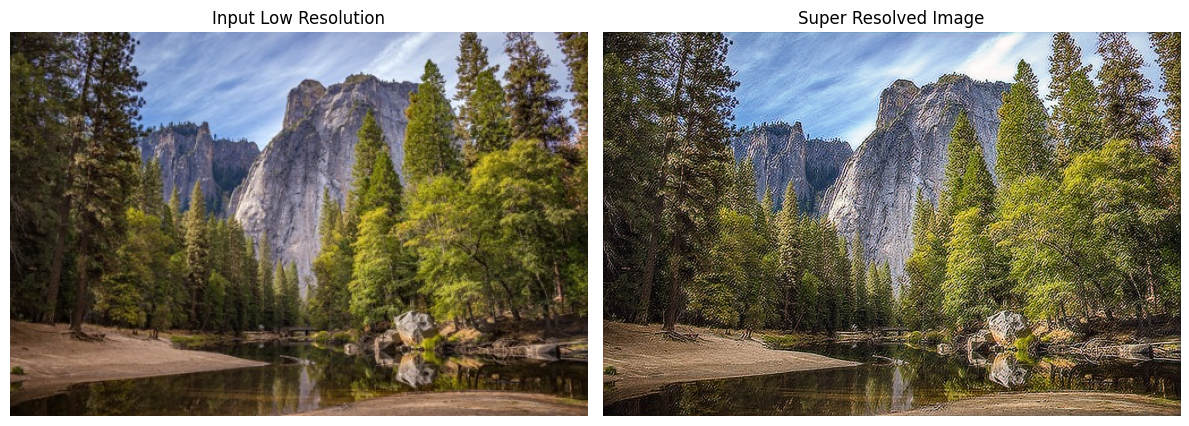

PSNR: 15.86 dB


In [18]:

import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2


# Initialize the optimizer (example for generator)
def initialize_optimizer(generator):
    return torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


# Load trained model and optionally the optimizer state
def load_trained_model(model_path, load_optimizer=False, optimizer=None):
    """
    Load a trained generator model and optionally the optimizer state.
    """
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model = Generator().to(DEVICE)
    model.load_state_dict(checkpoint['generator_state_dict'])

    if load_optimizer and optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_G_state_dict'])

    model.eval()
    return model, optimizer, checkpoint.get('epoch', 0), checkpoint.get('g_loss', 0), checkpoint.get('d_loss', 0), checkpoint.get('psnr', 0), checkpoint.get('ssim', 0)


# Test and visualize the result
def test_and_visualize(model, test_image_path, save_path=None):
    """
    Test the model on a single image and visualize the input and predicted results side by side.
    """
    img = Image.open(test_image_path).convert('RGB')

    # No transformation here, keeping the image as it is
    low_res = np.array(img).astype(np.float32) / 255.0

    # Convert the image to a PyTorch tensor
    low_res_tensor = torch.tensor(low_res).permute(2, 0, 1).unsqueeze(0).to(DEVICE)

    # Generate super-resolved image
    with torch.no_grad():
        super_res = model(low_res_tensor)

    # Convert tensors to images for visualization
    low_res_img = low_res  # Directly use the original low-res image
    super_res_img = super_res.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Normalize for visualization
    low_res_img = np.clip(low_res_img, 0, 1)
    super_res_img = np.clip(super_res_img, 0, 1)

    # Plot the input and super-resolved images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(low_res_img)
    axes[0].set_title('Input Low Resolution')
    axes[0].axis('off')

    axes[1].imshow(super_res_img)
    axes[1].set_title('Super Resolved Image')
    axes[1].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Result saved to {save_path}")

    plt.show()

    # Resize the original image to match super-resolved dimensions for metrics
    original_resized = cv2.resize(low_res_img, (super_res_img.shape[1], super_res_img.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Compute PSNR without SSIM
    psnr_value = psnr(original_resized, super_res_img, data_range=1)

    print(f"PSNR: {psnr_value:.2f} dB")


# Example usage
if __name__ == "__main__":
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize generator
    generator = Generator().to(DEVICE)

    # Load your trained model from checkpoint
    model_path = "/content/checkpoint_epoch_100.pth"  # Adjust to your model path
    optimizer = initialize_optimizer(generator)
    generator, optimizer, epoch, g_loss, d_loss, psnr_val, ssim_val = load_trained_model(model_path, load_optimizer=True, optimizer=optimizer)

    # Test single image
    test_image_path = "/content/WhatsApp Image 2025-01-14 at 02.30.20_796bec22.jpg"
    test_and_visualize(generator, test_image_path, save_path="single_result.png")
